In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import calendar
plt.style.use('ggplot')
import seaborn as sns
import datetime
pd.set_option('display.max_columns', 500)
from scipy.stats import ttest_ind,boxcox,chi2_contingency

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
from state_abbr import states as states_dict

FIG_SIZE = (15,5)

In [2]:
size = 'medium' # ['small','medium','large']
flights = pd.read_csv("flights_{0}.csv".format(size))
flights["Date"] = pd.to_datetime(flights["Date"])
n,m = flights.shape
any_nans = flights.isnull().values.any()
print("n observations = {0:,}. n features = {1}. Any NANs = {2}".format(n,m,any_nans))

n observations = 1,000,000. n features = 19. Any NANs = False


### Get year, month of flight and add full departure state name

In [3]:
flights.insert(loc=1,column="month",value=pd.DatetimeIndex(flights['Date']).month)
flights.insert(loc=1,column="year",value=pd.DatetimeIndex(flights['Date']).year)
flights['Departure_State_Full'] = flights.Departure_State.apply(lambda state: states_dict[state])
flights[["Date","year","month",'Departure_State_Full','Departure_State']].head(20)

,Date,year,month,Departure_State_Full,Departure_State
0,2009-04-24,2009,4,Connecticut,CT
1,2009-04-29,2009,4,Connecticut,CT
2,2010-04-30,2010,4,Connecticut,CT
3,2010-04-15,2010,4,Connecticut,CT
4,2010-12-24,2010,12,Connecticut,CT
5,2010-04-27,2010,4,Connecticut,CT
6,2010-09-22,2010,9,Connecticut,CT
7,2008-10-09,2008,10,Connecticut,CT
8,2008-12-01,2008,12,Florida,FL
9,2010-01-18,2010,1,Georgia,GA


### What is the trend over time in number of flights?

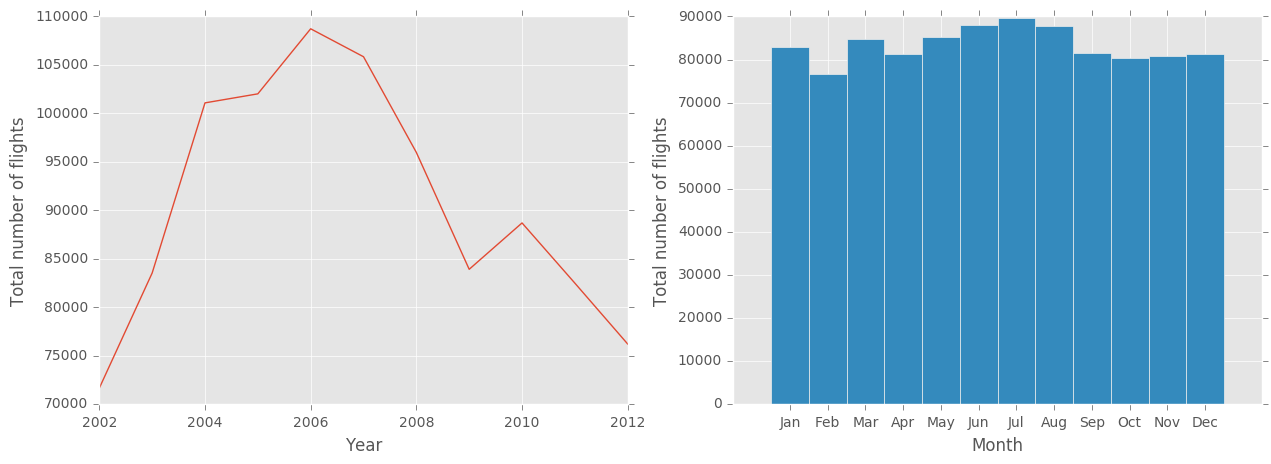

In [4]:
flights_by_year = flights.groupby('year').size()
flights_by_month = flights.groupby('month').size()
f, (ax1, ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
months = flights_by_month.index 
months_names = [calendar.month_abbr[mon] for mon in months]
width=1.0
ax1.plot(flights_by_year); ax1.set_xlabel("Year"); ax1.set_ylabel("Total number of flights")
ax2.bar(months,flights_by_month,width=width); ax2.set_xticklabels(months_names); ax2.set_xticks(months + width / 2);
ax2.set_xlabel("Month"); ax2.set_ylabel("Total number of flights")
plt.show()

* Flights by year shows decrease in total annual flights after 2006. Possibly due to financial crash.
* Flights by month differences might possibly be related to US holidays.

### Departure traffic by state

In [5]:
state_dep_counts = pd.DataFrame(flights["Departure_State"].value_counts())
scl = [[0.0, 'rgb(242,240,247)'],[0.2, 'rgb(218,218,235)'],[0.4, 'rgb(188,189,220)'],\
            [0.6, 'rgb(158,154,200)'],[0.8, 'rgb(117,107,177)'],[1.0, 'rgb(84,39,143)']]

data = [ dict(type='choropleth', colorscale = scl, autocolorscale = False,
        locations = state_dep_counts.index,
        z = state_dep_counts['Departure_State'].astype(float),
        locationmode = 'USA-states',
        marker = dict(line = dict (color = 'rgb(255,255,255)',width = 2)),
        colorbar = dict(title = "Departure total traffic")
    ) ]

layout = dict(title = 'Departure total traffic',
        geo = dict(scope='usa',projection=dict( type='albers usa' ),showlakes = True,lakecolor = 'rgb(255, 255, 255)'),
    )
fig = dict( data=data, layout=layout )
iplot(data)  

# Delay times? 

[Top reasons for delays](http://www.mro-network.com/maintenance-repair-overhaul/top-5-reasons-flight-delays/gallery?slide=5)
* late arriving aircraft - can't obtain this feature as we don't have a unique plane id in dataset.
* air carrier delays - no info
* heavy traffic volume - can model this
* extreme weather - can model this
* security lines - no info.

### Delays are highly skewed (focus on departure delays as opposed to arrivals)

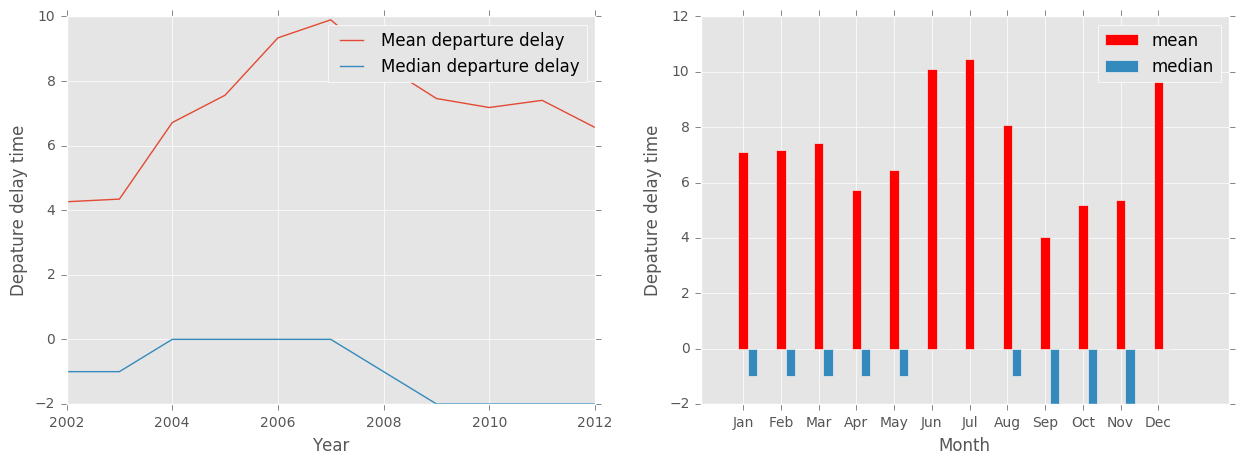

In [6]:
departure_delay_year = flights[["Departure_delay","year"]].groupby("year").agg(["mean","median"]) 
departure_delay_month = flights[["Departure_delay","month"]].groupby('month').agg(["mean","median"])
f, (ax1, ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
ax1.plot(departure_delay_year)
ax1.legend(("Mean departure delay","Median departure delay"))
ax1.set_ylabel("Depature delay time"); ax1.set_xlabel("Year")

width = 0.25
ax2.bar(months,departure_delay_month["Departure_delay"]["mean"].values,width=width,color='red');
ax2.bar(months+width,departure_delay_month["Departure_delay"]["median"].values,width=width);
ax2.set_xticklabels(months_names); ax2.set_xticks(months + width / 2);
ax2.set_xlabel("Month"); ax2.set_ylabel("Depature delay time")
ax2.legend(("mean","median"))
plt.show()

* Delays seem to be correlated with overall traffic. E.g. delays are more likely to be long in high traffic months such as june, july as well as high traffic years e.g. 2006. 
* Delays also very higher in winter months as expected.
* Mean >> Median implying positivley skewed delays. I.e there are few very long delays

### Remove 'quick' flights, outliers and visualize log delays

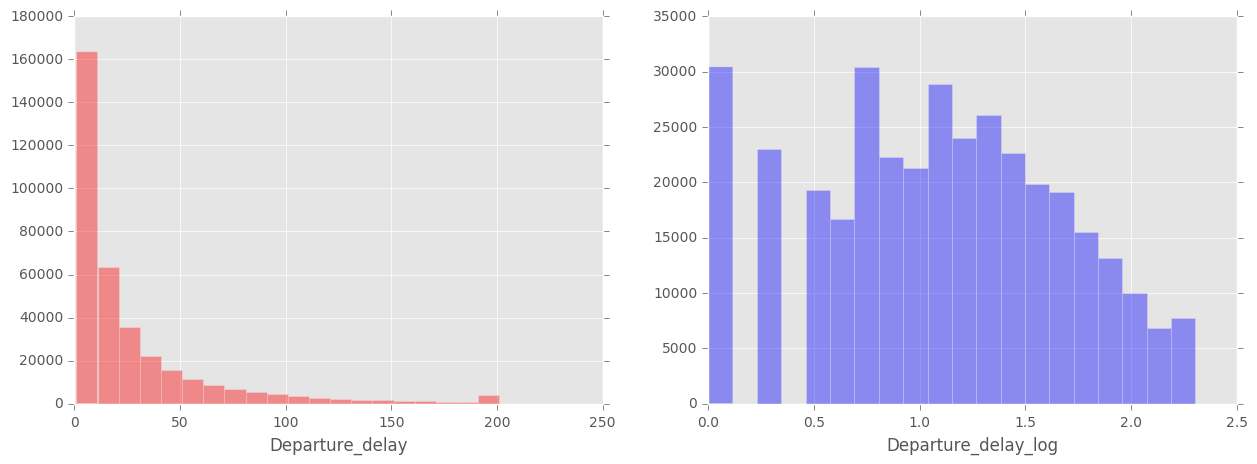

In [7]:
flights = flights[flights['Departure_delay']>0] # not interested in 'quick' flights. Helps with sampling underrepresented long delay examples when trying to predict later on.
quantile_upper_clip = np.percentile(flights['Departure_delay'],99)
flights['Departure_delay'] = flights.Departure_delay.clip_upper(quantile_upper_clip) #anything bigger than 99th percentile set to 99th quntile

flights['Departure_delay_log'] = flights['Departure_delay'].apply(lambda x: np.log10(x))
f, (ax1, ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
sns.distplot(flights['Departure_delay'],ax=ax1,label='delays',color='red',bins=20,kde=False)
sns.distplot(flights['Departure_delay_log'],ax=ax2,label='log delays',color='blue',bins=20,kde=False); plt.show()

* If predicting continous variable, $log_{10}$ version may be better

### FEATURE SELECT - Bin response variable ```Departure_delay``` into (0-30], (30-60]

In [8]:
flights['Departure_delay_bin'] = pd.cut(flights['Departure_delay'],
                                        bins=(0,30,quantile_upper_clip+1),
                                        labels=("No delay","Delay"))
flights['Departure_delay_bin'].value_counts()/flights.shape[0]

No delay    0.735384
Delay       0.264616
Name: Departure_delay_bin, dtype: float64

### Functions to use later on

In [9]:
class Cross_tab(): # cross tabulate two variables and do chi2 test of independence. reject if p value is small i.e. good predictor
    def __init__(self,var1,var2):
        self.cross_tab = pd.crosstab(var1,var2)
        
    def chi2_test(self,alpha=0.01):
        chi2_test = chi2_contingency(self.cross_tab)
        self.pval = chi2_test[1]
        if self.pval < alpha:
            result = 'reject independence'
        else:
            result = 'accept null of independence'
        print(self.cross_tab)
        print(self.cross_tab.div(self.cross_tab.sum(axis=1),axis=0))
        print('\n P value = {0:.6f}. {1}'.format(self.pval,result))

def plot_two_dist(dist1,dist2,title_append=''): # plot function used later
    dist1_n, dist2_n = dist1['values'].size, dist2['values'].size
    f, ax1 = plt.subplots(1, 1,figsize=FIG_SIZE)
    sns.distplot(dist1['values'],ax=ax1,label=dist1['name'],color='red',bins=15)
    sns.distplot(dist2['values'],ax=ax1,label=dist2['name'],color='blue',bins=15)
    ax1.vlines(dist1['values'].mean(), 0, 1,colors='red')
    ax1.vlines(dist2['values'].mean(), 0, 1,colors='blue')
    plt.title("Counts for {0}={1}, {2}={3}. {4}".format(dist1['name'],dist1_n,
                                                   dist2['name'],dist2_n,
                                                     title_append))
    plt.legend()
    plt.show()

### Delays arguably related to weather which is related to location. Should see relationship between latitude ("north-south") and delay time

In [10]:
flights['latitude_bin'] = np.where(flights.Latitude>40,'north','south') # anything above 40 lat classes as north
Lat_contingency = Cross_tab(flights['latitude_bin'],flights['Departure_delay_bin'])
Lat_contingency.chi2_test()

Departure_delay_bin  No delay  Delay
latitude_bin                        
north                   71174  28033
south                  191589  66518
Departure_delay_bin  No delay     Delay
latitude_bin                           
north                0.717429  0.282571
south                0.742285  0.257715

 P value = 0.000000. reject independence


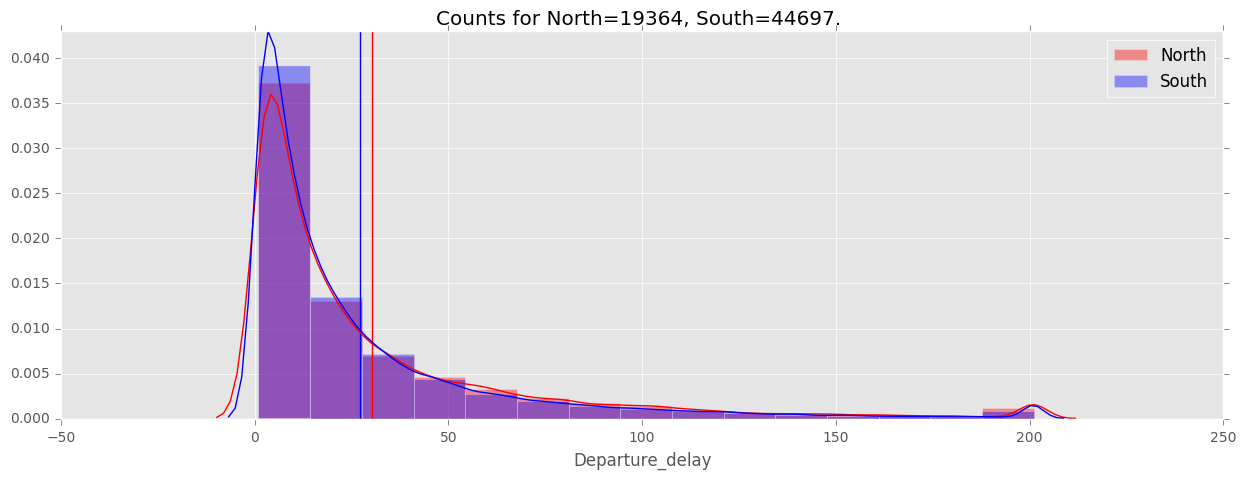

In [11]:
flights_winter = flights[flights['month'].isin([1,12])] # winter months
north_delays_winter = flights_winter[(flights_winter['latitude_bin']=='north')]['Departure_delay']
south_delays_winter = flights_winter[(flights_winter['latitude_bin']=='south')]['Departure_delay']
dist1={'values':north_delays_winter,'name':'North'}
dist2={'values':south_delays_winter,'name':'South'}
plot_two_dist(dist1,dist2)

* some difference in continous departure delays. possibly need specific weather information
* we do reject null hypothesis of independence between departure_delay_bins and our latitude variable however

### Load weather, look at wind/snow by date and aiport (departure airport)

In [12]:
weather = pd.read_csv("weather.csv")
weather["Date"] = pd.to_datetime(weather["Date"])
weather = weather.rename(columns={"airport": "Departure_Airport"})

### if snow and rain do not change (i.e. std==0) by day at each airport then we can just merge our flight data and weather data and keep any one of the time values

In [13]:
weather_by_date_airport = weather[['snow','wind',"Date","Departure_Airport"]].groupby(["Date","Departure_Airport"]).agg(['std'])
np.any(weather_by_date_airport>0) # snow and rain values do not change each day given an airport.
weather.drop('time',axis=1,inplace=True) # therefore time is redundant
weather.drop_duplicates(inplace=True) 
flights_weather = flights.merge(weather,how='left',on=["Date","Departure_Airport"], indicator=True) # merge with flight data.

### assume null = 0. i.e. no entry has been entered into dataset if no snow or wind

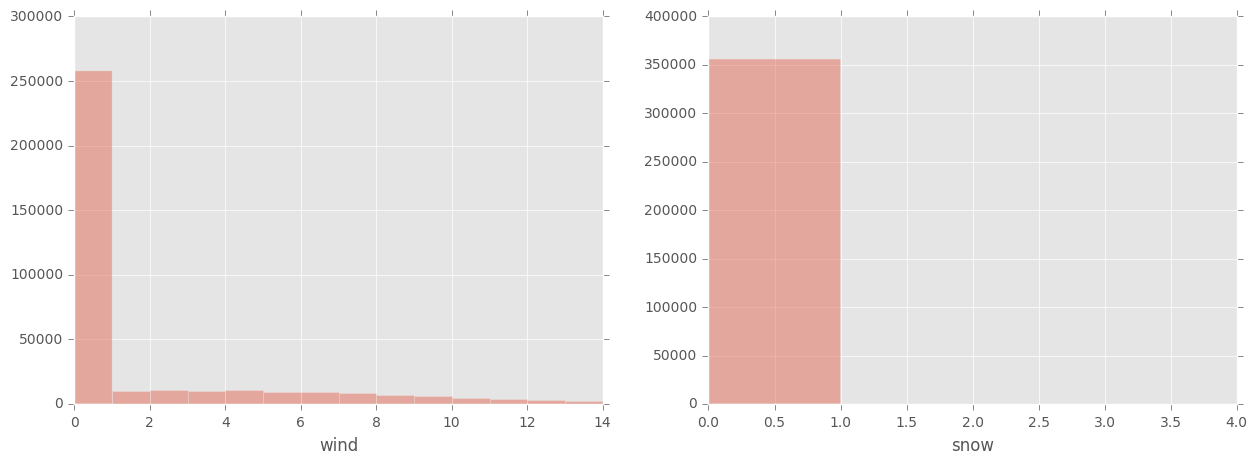

In [14]:
flights_weather[['snow','wind']] = flights_weather[['snow','wind']].fillna(0)
f, (ax1,ax2) = plt.subplots(1, 2,figsize=FIG_SIZE)
sns.distplot(flights_weather.wind,bins=np.arange(0,15,1),ax=ax1,label='wind',kde=False)
sns.distplot(flights_weather.snow,bins=np.arange(0,5,1),ax=ax2,label='snow',kde=False)
plt.show()

* Incredibly sparse variables, best to bin

### Check delay distribution by whether or not snow was present. Loop over a snow threshold

In [15]:
for snow_value in range(1,20,5):
    print("\n Snow bool threshold = {0}".format(snow_value))
    flights_weather['snow_bool'] = flights_weather[['snow']] > snow_value
    snow_contingency = Cross_tab(flights_weather['snow_bool'],flights_weather['Departure_delay_bin'])
    snow_contingency.chi2_test()
    
    def snow_plot():
        no_snow = flights_weather['Departure_delay'][flights_weather.snow_bool==0]
        snow = flights_weather['Departure_delay'][flights_weather.snow_bool==1]
        dist1={'values':no_snow,'name':'No snow'}
        dist2={'values':snow,'name':'Snow'}
        title = 'snow var > {0}'.format(snow_value)
        plot_two_dist(dist1,dist2,title_append=title)


 Snow bool threshold = 1
Departure_delay_bin  Delay  No delay
snow_bool                           
False                94254    262173
True                   297       590
Departure_delay_bin     Delay  No delay
snow_bool                              
False                0.264441  0.735559
True                 0.334837  0.665163

 P value = 0.000002. reject independence

 Snow bool threshold = 6
Departure_delay_bin  Delay  No delay
snow_bool                           
False                94504    262660
True                    47       103
Departure_delay_bin     Delay  No delay
snow_bool                              
False                0.264596  0.735404
True                 0.313333  0.686667

 P value = 0.207561. accept null of independence

 Snow bool threshold = 11
Departure_delay_bin  Delay  No delay
snow_bool                           
False                94541    262746
True                    10        17
Departure_delay_bin     Delay  No delay
snow_bool                

* small difference in distributions which gets greater the higher the threshold of 'snow_bool'. Number of events gets very small however.
* try snow thresh over 1

### Do the same but with wind.

In [16]:
for wind_value in range(1,20,4):
    print("\n\nWind = " + str(wind_value))
    flights_weather['wind_bin'] = flights_weather['wind'] > wind_value
    snow_contingency = Cross_tab(flights_weather['wind_bin'],flights_weather['Departure_delay_bin'])
    snow_contingency.chi2_test()



Wind = 1
Departure_delay_bin  Delay  No delay
wind_bin                            
False                67443    191342
True                 27108     71421
Departure_delay_bin     Delay  No delay
wind_bin                               
False                0.260614  0.739386
True                 0.275127  0.724873

 P value = 0.000000. reject independence


Wind = 5
Departure_delay_bin  Delay  No delay
wind_bin                            
False                78628    221949
True                 15923     40814
Departure_delay_bin     Delay  No delay
wind_bin                               
False                0.261590  0.738410
True                 0.280646  0.719354

 P value = 0.000000. reject independence


Wind = 9
Departure_delay_bin  Delay  No delay
wind_bin                            
False                87371    245473
True                  7180     17290
Departure_delay_bin     Delay  No delay
wind_bin                               
False                0.262498  0.737502

### Ice or no ice (sub zero). Assume mean temperature for missing

In [23]:
flights_weather.temperature.fillna(flights_weather.temperature.mean(),inplace=True)
flights_weather['temperature'].describe()

count    357314.000000
mean         61.402674
std           9.580828
min         -19.000000
25%          61.402674
50%          61.402674
75%          61.402674
max         106.000000
Name: temperature, dtype: float64

* Must be in farenheit

Departure_delay_bin  Delay  No delay
sub_zero                            
False                92606    258403
True                  1945      4360
Departure_delay_bin     Delay  No delay
sub_zero                               
False                0.263828  0.736172
True                 0.308485  0.691515

 P value = 0.000000. reject independence


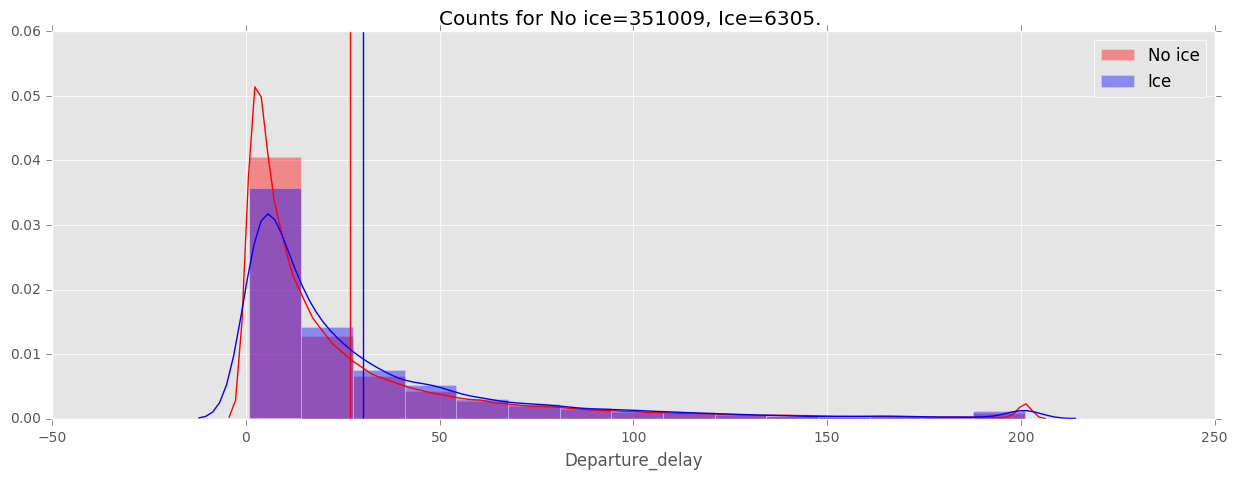

In [18]:
flights_weather['sub_zero'] = flights_weather['temperature'] < 32 #0C = 32F
snow_contingency = Cross_tab(flights_weather['sub_zero'],flights_weather['Departure_delay_bin'])
snow_contingency.chi2_test()

no_ice = flights_weather['Departure_delay'][flights_weather.sub_zero==False] ## may not be actual ice, just a name.
ice = flights_weather['Departure_delay'][flights_weather.sub_zero==True]
dist1={'values':no_ice,'name':'No ice'}
dist2={'values':ice,'name':'Ice'}
plot_two_dist(dist1,dist2)

* "Ice" is quite rare event but looks like it increases delays
* Reject our null of independence

### Flights delays by airport

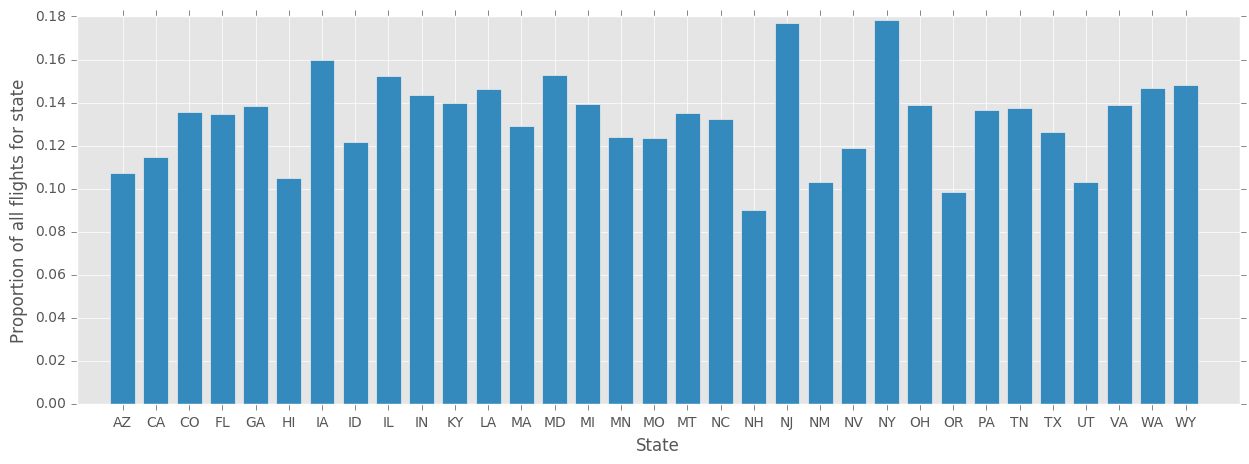

In [19]:
delays_state = pd.crosstab(flights_weather['Departure_State'],flights_weather['Departure_delay_bin'])
delays_state['total'] = delays_state.sum(1)
delays_state = delays_state[delays_state.total>1000] # consider states who have had at least 1000 flights
delays_state_prop = delays_state.drop('total',axis=1).div(delays_state.sum(axis=1), axis=0)
state_delays = delays_state_prop["Delay"]
f, ax1 = plt.subplots(1, 1,figsize=FIG_SIZE)
names = state_delays.index
idx = np.arange(1,names.size+1)
width=0.75
ax1.bar(idx,state_delays.values,width=width); ax1.set_xticklabels(names.tolist()); ax1.set_xticks(idx + width / 2);
ax1.set_xlabel("State"); ax1.set_ylabel("Proportion of all flights for state")
plt.show()

* NJ and NY seem to have the most delays

### time of day and delays - clean 'Departure_schedule' to datetime object

In [20]:
flights_weather['Departure_schedule'] = flights_weather['Departure_schedule'].astype(str)
def add_0(time):
    if len(time) == 1:
        return '000' + time
    elif len(time) == 2:
        return '00' + time
    elif len(time) == 3:
        return '0'+time
    else:
        return time
flights_weather['Departure_schedule'] = flights_weather['Departure_schedule'].apply(add_0)
flights_weather['Departure_schedule_hour'] = pd.to_datetime(flights_weather['Departure_schedule'], format='%H%M').dt.hour
flights_weather['Time_of_day'] = pd.cut(flights_weather['Departure_schedule_hour'],np.arange(0,30,6),right=False,labels=['Early morning','Morning','Afternoon','Evening'])
flights_weather[['Departure_schedule','Departure_schedule_hour','Time_of_day']].sample(5) # example

,Departure_schedule,Departure_schedule_hour,Time_of_day
250790,2130,21,Evening
15050,0640,6,Morning
256676,1700,17,Afternoon
277541,1025,10,Morning
294030,1840,18,Evening


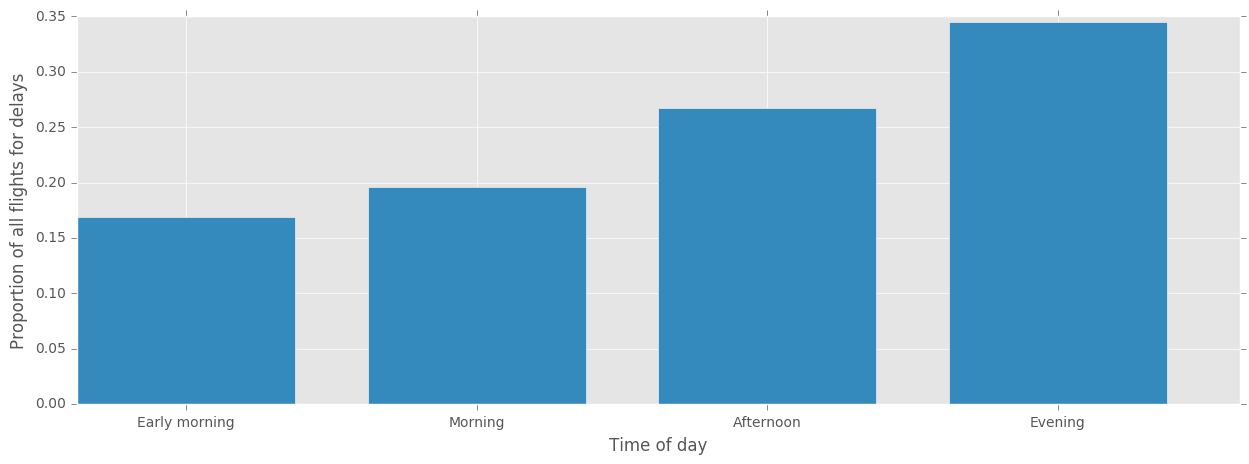

Departure_delay_bin  Delay  No delay
Time_of_day                         
Early morning          352      1738
Morning              21144     86862
Afternoon            42153    115591
Evening              30902     58572
Departure_delay_bin     Delay  No delay
Time_of_day                            
Early morning        0.168421  0.831579
Morning              0.195767  0.804233
Afternoon            0.267224  0.732776
Evening              0.345374  0.654626

 P value = 0.000000. reject independence


In [21]:
Time_of_day_delays = Cross_tab(flights_weather['Time_of_day'],flights_weather['Departure_delay_bin'])
time_of_day_delays = Time_of_day_delays.cross_tab
time_of_day_delays_prop = time_of_day_delays.div(time_of_day_delays.sum(axis=1), axis=0)
time_of_day_long_delays = time_of_day_delays_prop["Delay"]
f, ax1 = plt.subplots(1, 1,figsize=FIG_SIZE)
names = time_of_day_delays_prop.index
idx = np.arange(1,names.size+1)
width=0.75
ax1.bar(idx,time_of_day_long_delays.values,width=width); ax1.set_xticklabels(names.tolist()); ax1.set_xticks(idx + width / 2);
ax1.set_xlabel("Time of day"); ax1.set_ylabel("Proportion of all flights for delays")
plt.show()
Time_of_day_delays.chi2_test()

* Evening flights have high proportion of long delays

# <center>Machine Learning Model</center>

## Try to predict our ```Departure_delay_bin``` variable



In [22]:
from sklearn.cross_validation import StratifiedShuffleSplit as SSS
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.metrics import log_loss
import numpy.random as rng

/Users/matt/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



## !!!!FEATURESELECTION based on above observations/intuition

In [100]:
class Train():
    def __init__(self,X,Y,n_estimators):
        X = pd.get_dummies(X)
        self.vars = X.columns
        le = LE()
        Y = le.fit_transform(Y)
        sss = SSS(y=Y,n_iter=1,test_size=0.2,random_state=1006)
        for tr_idx, te_idx in sss:
            X_tr, X_te = X.ix[tr_idx], X.ix[te_idx]
            Y_tr, Y_te = Y[tr_idx], Y[te_idx]
        print("Train and test sizes are {0} and {1}".format(X_tr.shape,X_te.shape))
        rf = RF(n_estimators=n_estimators)
        rf.fit(X_tr,Y_tr)
        self.rf = rf
        self.X, self.Y = X, Y
        guess = (pd.Series(Y_tr).value_counts().sort_index()/Y_tr.shape).as_matrix() # guess equal to proportions 
        guesses = np.tile(guess,Y_te.size).reshape(Y_te.size,2)
        Y_tr_pred = rf.predict_proba(X_tr)
        Y_te_pred = rf.predict_proba(X_te)

        log_loss_tr = log_loss(y_true = Y_tr, y_pred = Y_tr_pred)
        log_loss_te = log_loss(y_true = Y_te, y_pred = Y_te_pred)
        log_loss_to_beat = log_loss(y_true = Y_te, y_pred = guesses)

        print("Train error = {0:.4f}. Test error = {1:.4f}. log_loss_to_beat = {2:.4f}.\n".format(log_loss_tr,log_loss_te,log_loss_to_beat))

        print("Feature importances")
        for feat,feat_import in zip(self.vars,self.rf.feature_importances_):
            print("{0} has importance of {1:.4f}.".format(feat,feat_import))

# Hyperparams

In [ ]:
n_estimators = 50
max_leaf_nodes = 50
max_depth = 20

snow_value = 1
wind_value = 10
ice = 40
min_obs_airports = 20000
min_obs_airline = 20000
XY = flights_weather.copy()
print(flights_weather.columns)

airline_states_few = XY['Airline'].value_counts()[XY['Airline'].value_counts()<min_obs_airline].index
XY['Airline'] = np.where(XY['Airline'].isin(airline_states_few),'grouped',XY['Airline'])

dep_states_few = XY['Departure_State'].value_counts()[XY['Departure_State'].value_counts()<min_obs_airports].index
XY['Departure_State'] = np.where(XY['Departure_State'].isin(dep_states_few),'grouped',XY['Departure_State'])

XY['latitude_bin'] = np.where(XY.Latitude>40,'north','south') 

XY['Time_of_day'] = pd.cut(XY['Departure_schedule_hour'],
                                        np.array([0,12,18,24]),right=False,
                                        labels=['Morning','Afternoon','Evening'])

XY['snow_bool'] = XY[['snow']] > snow_value
XY['wind_bin'] = XY['wind'] > wind_value
XY['sub_zero'] = XY['temperature'] < ice #0C = 32F

x_keep = ['month','year','Time_of_day',
          'latitude_bin','Departure_State','sub_zero',
         'snow_bool','Airline']
X = XY[x_keep]
Y = flights_weather["Departure_delay_bin"]
train = Train(X,Y,n_estimators)
print(X.head())

Index(['Date', 'year', 'month', 'Airline', 'Airline_code', 'Arrival_airport',
       'Arrival_state', 'Departure_Airport', 'Departure_State',
       'Departure_actual', 'Departure_delay', 'Arrival_actual',
       'Arrival_delay', 'Arrival_schedule', 'Departure_schedule',
       'DC_Longitude', 'DC_Latitude', 'Longitude', 'Latitude', 'Route',
       'Path_order', 'Departure_State_Full', 'Departure_delay_log',
       'Departure_delay_bin', 'latitude_bin', 'temperature', 'snow', 'wind',
       '_merge', 'snow_bool', 'wind_bin', 'sub_zero',
       'Departure_schedule_hour', 'Time_of_day'],
      dtype='object')
Train and test sizes are (285851, 20) and (71463, 20)
